In [1]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)
print(model['United_States'])
print(model['United_States'].shape)

[-3.61328125e-02 -4.83398438e-02  2.35351562e-01  1.74804688e-01
 -1.46484375e-01 -7.42187500e-02 -1.01562500e-01 -7.71484375e-02
  1.09375000e-01 -5.71289062e-02 -1.48437500e-01 -6.00585938e-02
  1.74804688e-01 -7.71484375e-02  2.58789062e-02 -7.66601562e-02
 -3.80859375e-02  1.35742188e-01  3.75976562e-02 -4.19921875e-02
 -3.56445312e-02  5.34667969e-02  3.68118286e-04 -1.66992188e-01
 -1.17187500e-01  1.41601562e-01 -1.69921875e-01 -6.49414062e-02
 -1.66992188e-01  1.00585938e-01  1.15722656e-01 -2.18750000e-01
 -9.86328125e-02 -2.56347656e-02  1.23046875e-01 -3.54003906e-02
 -1.58203125e-01 -1.60156250e-01  2.94189453e-02  8.15429688e-02
  6.88476562e-02  1.87500000e-01  6.49414062e-02  1.15234375e-01
 -2.27050781e-02  3.32031250e-01 -3.27148438e-02  1.77734375e-01
 -2.08007812e-01  4.54101562e-02 -1.23901367e-02  1.19628906e-01
  7.44628906e-03 -9.03320312e-03  1.14257812e-01  1.69921875e-01
 -2.38281250e-01 -2.79541016e-02 -1.21093750e-01  2.47802734e-02
  7.71484375e-02 -2.81982

In [2]:
import pandas as pd
import numpy as np
columns = ['label', 'text']
labels = {'b': 0, 't': 1, 'e': 2, 'm': 3}
def read_txt(name):
    df = pd.DataFrame(columns=columns)
    with open(f'./{name}.txt', 'r') as f:
        lines = f.readlines()

    for l in lines:
        label = labels[l[0]]
        text = l[2:]
        sr = pd.Series([label, text])
        df = pd.concat([df, pd.DataFrame(sr.values.reshape(1,-1), columns=columns)], axis=0)
    
    return df

train_df = pd.DataFrame(columns=columns)
valid_df = pd.DataFrame(columns=columns)
test_df = pd.DataFrame(columns=columns)
train_df = read_txt('train')
valid_df = read_txt('valid')
test_df = read_txt('test')

train_df['label'].value_counts()

label
0    4481
2    4240
1    1214
3     737
Name: count, dtype: int64

In [3]:
y_train = np.array(train_df['label'])
y_valid = np.array(valid_df['label'])
y_test = np.array(test_df['label'])

In [4]:
def vectorize(df):
    X = []
    for i in range(len(df)):
        text = df.iloc[i]['text'].replace('...', '')
        words = text.split()
        vecs = []
        for w in words:
            try:
                vec = model[w]
            except:
                vec = [0] * 300
            vecs.append(vec)
        vecs = np.array(vecs)
        X.append(np.mean(vecs, axis=0))
    return np.array(X)
X_train = vectorize(train_df)
X_valid = vectorize(valid_df)
X_test = vectorize(test_df)
print(X_valid.shape, y_valid.shape)

np.save('./data/X_train', X_train)
np.save('./data/X_valid', X_valid)
np.save('./data/X_test', X_test)
np.save('./data/y_train', y_train)
np.save('./data/y_valid', y_valid)
np.save('./data/y_test', y_test)

(1334, 300) (1334,)


In [30]:
def softmax(X):
    Y = np.zeros(X.shape)
    for i in range(X.shape[0]):
        x = X[i]
        u = np.sum(np.exp(x))
        Y[i] = np.exp(x)/u
    return Y

W = np.random.rand(X_train.shape[1], 4)
arr1 = np.dot(X_train[0], W)
arr2 = np.dot(X_train[:4], W)
y_h = softmax(arr1.reshape(1,-1))
Y_h = softmax(arr2)
print(y_h)
print(Y_h)

[[0.26925589 0.23516366 0.18075532 0.31482513]]
[[0.26925589 0.23516366 0.18075532 0.31482513]
 [0.27871925 0.21475735 0.24964409 0.25687931]
 [0.26180623 0.21482765 0.26645002 0.25691611]
 [0.29311885 0.25514649 0.20816675 0.24356791]]


In [41]:
def calc_loss(Y_pred, y_true):
    l = 0
    for i in range(Y_pred.shape[0]):
        l += -1 * np.log(Y_pred[i][y_true[i]])
    l /= Y_pred.shape[0]
    return l

l_1 = calc_loss(y_h, [y_train[0]])
l_2 = calc_loss(Y_h, y_train[:4])
print(l_1)
print(l_2)

1.3120930841204022
1.397949126379722


In [122]:
## SGD
import torch
import torch.nn as nn
import torch.optim as optim

def softmax(X):
    Y = np.zeros(X.shape)
    for i in range(X.shape[0]):
        x = X[i]
        u = np.sum(np.exp(x))
        Y[i] = np.exp(x)/u
    return Y

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(300,4)
        nn.init.normal_(self.fc1.weight, 0.0, 1.0)
    def forward(self,x):
        x = self.fc1(x)
        return x

In [124]:
from torch.utils.data import Dataset

class NewsDataset(Dataset):
  def __init__(self, X, y):  # datasetの構成要素を指定
    self.X = X
    self.y = y

  def __len__(self):  # len(dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, idx):  # dataset[idx]で返す値を指定
    return [self.X[idx], self.y[idx]]

In [128]:
from torch.utils.data import DataLoader

X_train_tensor = torch.from_numpy(X_train.astype(np.float32))
X_valid_tensor = torch.from_numpy(X_valid.astype(np.float32))
X_test_tensor = torch.from_numpy(X_test.astype(np.float32))

dataset_train = NewsDataset(X_train_tensor, y_train)
dataset_valid = NewsDataset(X_valid_tensor, y_valid)
dataset_test = NewsDataset(X_test_tensor, y_test)

dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

In [135]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

num_epoch = 10
for epoch in range(num_epoch):
    model.train()
    loss_train = 0.0
    for i, (inputs, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_train += loss.item()
    
    loss_train = loss_train / len(dataloader_train)

    model.eval() 
    with torch.no_grad():
        inputs, labels = next(iter(dataloader_valid))
        outputs = model(inputs)
        loss_valid = criterion(outputs, labels)

    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')  

epoch: 1, loss_train: 0.5163, loss_valid: 0.3900
epoch: 2, loss_train: 0.3620, loss_valid: 0.3625
epoch: 3, loss_train: 0.3327, loss_valid: 0.3537
epoch: 4, loss_train: 0.3162, loss_valid: 0.3515
epoch: 5, loss_train: 0.3060, loss_valid: 0.3394
epoch: 6, loss_train: 0.2980, loss_valid: 0.3405
epoch: 7, loss_train: 0.2915, loss_valid: 0.3414
epoch: 8, loss_train: 0.2877, loss_valid: 0.3528
epoch: 9, loss_train: 0.2839, loss_valid: 0.3368
epoch: 10, loss_train: 0.2814, loss_valid: 0.3461


In [136]:
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.1581,  1.2723,  0.6204,  ...,  0.6563,  1.2444, -0.6489],
                      [ 2.1271,  0.8945,  1.9790,  ...,  0.1347, -2.0921, -0.9562],
                      [ 1.5047,  0.3856, -2.1583,  ...,  0.1969,  0.2468,  0.1364],
                      [ 0.3052, -0.1845, -0.0099,  ...,  1.1239,  0.9849,  2.1927]])),
             ('fc1.bias', tensor([ 0.1601,  0.0389,  1.7267, -1.9025]))])

In [140]:
def calc_loss_acc(model, criterion, loader):
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()
    return loss / len(loader), correct / total

loss_train, acc_train = calc_loss_acc(model, criterion, dataloader_train)
loss_test, acc_test = calc_loss_acc(model, criterion, dataloader_test)
print(f'train: {acc_train}\ntest: {acc_test}')

train: 0.8606634182908546
test: 0.843328335832084


In [144]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.05)
criterion = nn.CrossEntropyLoss()
num_epoch = 30

log_train = []
log_valid = []

for epoch in range(num_epoch):
    model.train()
    loss_train = 0.0
    for i, (inputs, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_train += loss.item()
    
    loss_train = loss_train / len(dataloader_train)

    loss_train, acc_train = calc_loss_acc(model, criterion, dataloader_train)
    loss_valid, acc_valid = calc_loss_acc(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')  
    

epoch: 1, loss_train: 0.4526, loss_valid: 0.4373
epoch: 2, loss_train: 0.3886, loss_valid: 0.3945
epoch: 3, loss_train: 0.3538, loss_valid: 0.3668
epoch: 4, loss_train: 0.3334, loss_valid: 0.3571
epoch: 5, loss_train: 0.3217, loss_valid: 0.3506
epoch: 6, loss_train: 0.3176, loss_valid: 0.3494
epoch: 7, loss_train: 0.3069, loss_valid: 0.3409
epoch: 8, loss_train: 0.2968, loss_valid: 0.3358
epoch: 9, loss_train: 0.2926, loss_valid: 0.3355
epoch: 10, loss_train: 0.2881, loss_valid: 0.3343
epoch: 11, loss_train: 0.2883, loss_valid: 0.3360
epoch: 12, loss_train: 0.2819, loss_valid: 0.3323
epoch: 13, loss_train: 0.2907, loss_valid: 0.3408
epoch: 14, loss_train: 0.2776, loss_valid: 0.3343
epoch: 15, loss_train: 0.2788, loss_valid: 0.3341
epoch: 16, loss_train: 0.2730, loss_valid: 0.3317
epoch: 17, loss_train: 0.2732, loss_valid: 0.3298
epoch: 18, loss_train: 0.2697, loss_valid: 0.3319
epoch: 19, loss_train: 0.2683, loss_valid: 0.3317
epoch: 20, loss_train: 0.2672, loss_valid: 0.3299
epoch: 21

### 75. 損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

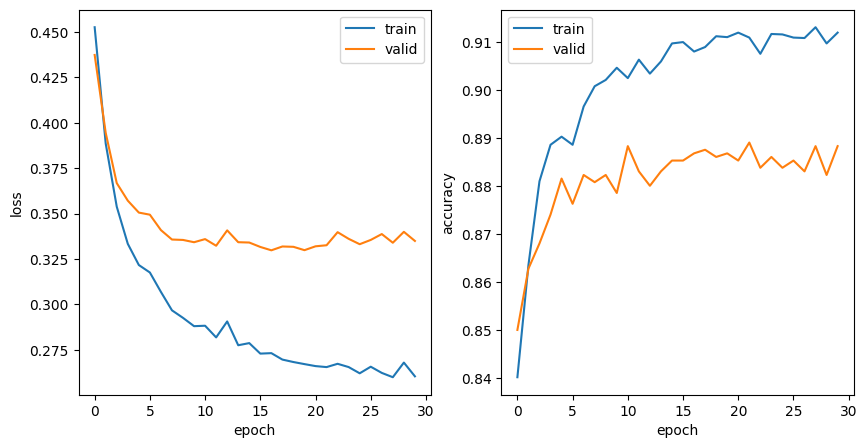

In [147]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot([l[0] for l in log_train], label='train')
ax[0].plot([l[0] for l in log_valid], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot([l[1] for l in log_train], label='train')
ax[1].plot([l[1] for l in log_valid], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

### 76. チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

In [63]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.05)
criterion = nn.CrossEntropyLoss()
num_epoch = 30

log_train = []
log_valid = []

for epoch in range(num_epoch):
    model.train()
    loss_train = 0.0
    for i, (inputs, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_train += loss.item()
    
    loss_train = loss_train / len(dataloader_train)

    loss_train, acc_train = calc_loss_acc(model, criterion, dataloader_train)
    loss_valid, acc_valid = calc_loss_acc(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    torch.save({'epoch': epoch+1, 'model': model.state_dict(), 'optimizer': optimizer.state_dict()}, f'./checkpoint/chpt{epoch+1}.pt')
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')  

RuntimeError: Tensor for 'out' is on CPU, Tensor for argument #1 'self' is on CPU, but expected them to be on GPU (while checking arguments for addmm)

In [149]:
chpt_15 = torch.load('./checkpoint/chpt15.pt')
chpt_15

{'epoch': 15,
 'model': OrderedDict([('fc1.weight',
               tensor([[-0.6915, -0.2605,  0.5325,  ..., -0.2305, -0.1752, -0.8984],
                       [ 1.1867,  0.1870,  1.0034,  ..., -0.2187, -3.4911,  0.2249],
                       [ 1.0728,  0.6875, -1.6922,  ..., -0.7220, -0.7426,  0.8257],
                       [-2.0930, -0.8952,  0.6244,  ...,  0.0182,  0.1495,  2.3421]])),
              ('fc1.bias', tensor([ 0.3135, -0.4250,  1.7785, -1.5858]))]),
 'optimizer': {'state': {0: {'momentum_buffer': None},
   1: {'momentum_buffer': None}},
  'param_groups': [{'lr': 0.05,
    'momentum': 0,
    'dampening': 0,
    'weight_decay': 0,
    'nesterov': False,
    'params': [0, 1]}]}}

### 77. ミニバッチ化
問題76のコードを改変し，B事例ごとに損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．Bの値を1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ．

In [160]:
import time
secs = []
def train(batch_size=1, num_epoch=10):
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    model = Net()
    optimizer = optim.SGD(model.parameters(), lr=0.05)
    criterion = nn.CrossEntropyLoss()
    num_epoch = num_epoch

    for epoch in range(num_epoch):
        start_time = time.time()
        model.train()
        loss_train = 0.0
        for i, (inputs, labels) in enumerate(dataloader_train):
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        
        loss_train = loss_train / len(dataloader_train)

        loss_train, acc_train = calc_loss_acc(model, criterion, dataloader_train)
        loss_valid, acc_valid = calc_loss_acc(model, criterion, dataloader_valid)

        end_time = time.time()
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}, time: {(end_time - start_time):.4f}sec') 

In [155]:
for b in [2**i for i in range(10)]:
    print(f'batch_size: {b}')
    train(batch_size=b, num_epoch=1)

batch_size: 1
epoch: 1, loss_train: 0.4642, loss_valid: 0.4633, time: 3.0684sec
batch_size: 2
epoch: 1, loss_train: 0.5503, loss_valid: 0.5492, time: 1.6975sec
batch_size: 4
epoch: 1, loss_train: 0.6677, loss_valid: 0.6648, time: 0.9081sec
batch_size: 8
epoch: 1, loss_train: 0.7998, loss_valid: 0.7518, time: 0.5242sec
batch_size: 16
epoch: 1, loss_train: 1.0443, loss_valid: 1.0272, time: 0.3272sec
batch_size: 32
epoch: 1, loss_train: 1.0694, loss_valid: 1.0345, time: 0.2254sec
batch_size: 64
epoch: 1, loss_train: 1.2916, loss_valid: 1.2762, time: 0.1708sec
batch_size: 128
epoch: 1, loss_train: 1.3164, loss_valid: 1.2846, time: 0.1409sec
batch_size: 256
epoch: 1, loss_train: 1.4647, loss_valid: 1.3960, time: 0.1117sec
batch_size: 512
epoch: 1, loss_train: 1.4183, loss_valid: 1.4022, time: 0.0895sec


### 78. GPU上での学習Permalink
問題77のコードを改変し，GPU上で学習を実行せよ．

In [1]:
# GPU確認
!nvidia-smi

Wed Jul 12 13:29:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:B2:00.0 Off |                    0 |
| N/A   34C    P0    40W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [73]:
def train(dataset_train, dataset_valid, model, batch_size=4, num_epoch=100, early_stopping=5):
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model.to(device)

    min_loss_valid = 100
    stop_count = 0

    log_train = []
    log_valid = []
    
    for epoch in range(num_epoch):
        start_time = time.time()
        model.train()
        loss_train = 0.0
        for i, (inputs, labels) in enumerate(dataloader_train):
            optimizer.zero_grad()

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        
        loss_train = loss_train / len(dataloader_train)

        loss_train, acc_train = calc_loss_acc(model, criterion, dataloader_train)
        loss_valid, acc_valid = calc_loss_acc(model, criterion, dataloader_valid)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        if loss_valid < min_loss_valid:
            min_loss_valid = loss_valid
            stop_count = 0
        else:
            stop_count += 1

        end_time = time.time()
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}, acc_train: {acc_train:.4f}, acc_valid: {acc_valid:.4f}, time: {(end_time - start_time):.4f}sec') 

        if stop_count == early_stopping:
            print('early stopping')
            return log_train, log_valid
        
    return log_train, log_valid


def calc_loss_acc(model, criterion, loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()
    return loss / len(loader), correct / total

In [43]:
from torch.utils.data import Dataset, DataLoader

class NewsDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return [self.X[idx], self.y[idx]]


X_train = np.load('./data/X_train.npy', allow_pickle=True)
X_valid = np.load('./data/X_valid.npy', allow_pickle=True)
X_test = np.load('./data/X_test.npy', allow_pickle=True)
y_train = np.load('./data/y_train.npy', allow_pickle=True)
y_valid = np.load('./data/y_valid.npy', allow_pickle=True)
y_test = np.load('./data/y_test.npy', allow_pickle=True)

X_train_tensor = torch.from_numpy(X_train.astype(np.float32))
X_valid_tensor = torch.from_numpy(X_valid.astype(np.float32))
X_test_tensor = torch.from_numpy(X_test.astype(np.float32))

dataset_train = NewsDataset(X_train_tensor, y_train)
dataset_valid = NewsDataset(X_valid_tensor, y_valid)
dataset_test = NewsDataset(X_test_tensor, y_test)

# dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
# dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
# dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

In [66]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(300,4)
        nn.init.normal_(self.fc1.weight, 0.0, 1.0)
    def forward(self,x):
        x = self.fc1(x)
        return x

In [68]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.05)
criterion = nn.CrossEntropyLoss()
log_train, log_valid = train(dataset_train=dataset_train, dataset_valid=dataset_valid, model=model, batch_size=1, num_epoch=10)

epoch: 1, loss_train: 0.4600, loss_valid: 0.4610, acc_train: 0.8360, acc_valid: 0.8388, time: 6.4729sec
epoch: 2, loss_train: 0.3856, loss_valid: 0.4030, acc_train: 0.8658, acc_valid: 0.8508, time: 6.5182sec
epoch: 3, loss_train: 0.3554, loss_valid: 0.3771, acc_train: 0.8778, acc_valid: 0.8561, time: 6.4970sec
epoch: 4, loss_train: 0.3357, loss_valid: 0.3669, acc_train: 0.8843, acc_valid: 0.8651, time: 6.4397sec
epoch: 5, loss_train: 0.3219, loss_valid: 0.3563, acc_train: 0.8906, acc_valid: 0.8703, time: 6.5226sec
epoch: 6, loss_train: 0.3156, loss_valid: 0.3533, acc_train: 0.8921, acc_valid: 0.8756, time: 6.4301sec
epoch: 7, loss_train: 0.3059, loss_valid: 0.3495, acc_train: 0.8946, acc_valid: 0.8748, time: 6.3852sec
epoch: 8, loss_train: 0.2997, loss_valid: 0.3461, acc_train: 0.9002, acc_valid: 0.8756, time: 6.4968sec
epoch: 9, loss_train: 0.2954, loss_valid: 0.3435, acc_train: 0.8995, acc_valid: 0.8801, time: 6.4807sec
epoch: 10, loss_train: 0.2918, loss_valid: 0.3441, acc_train: 0.

In [70]:
loss_test, acc_test = calc_loss_acc(model, criterion, dataloader_test)
print(f'accuracy: {acc_test}')

accuracy: 0.8860569715142429


### 79. 多層ニューラルネットワーク
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [109]:
from torch.nn import functional as F

class MLP(nn.Module):
    def __init__(self, mid_layer_num=2, mid_unit=200):
        super().__init__()
        self.mid_layer_num = mid_layer_num
        self.fc_in = nn.Linear(300, mid_unit)
        self.fc_mid = nn.Linear(mid_unit, mid_unit)
        self.fc_out = nn.Linear(mid_unit, 4)

    def forward(self,x):
        x = F.relu(self.fc_in(x))
        for i in range(self.mid_layer_num):
            x = F.relu(self.fc_mid(x))
        x = self.fc_out(x)
        return x

In [122]:
model = MLP(mid_layer_num=3, mid_unit=200)
optimizer = optim.SGD(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
log_train, log_valid = train(dataset_train=dataset_train, dataset_valid=dataset_valid, model=model, batch_size=16, num_epoch=300, early_stopping=10)

epoch: 1, loss_train: 1.1756, loss_valid: 1.1659, acc_train: 0.4199, acc_valid: 0.4310, time: 0.9401sec
epoch: 2, loss_train: 1.1624, loss_valid: 1.1504, acc_train: 0.4199, acc_valid: 0.4310, time: 0.9407sec
epoch: 3, loss_train: 1.1616, loss_valid: 1.1492, acc_train: 0.4199, acc_valid: 0.4310, time: 0.9418sec
epoch: 4, loss_train: 1.1609, loss_valid: 1.1490, acc_train: 0.4199, acc_valid: 0.4310, time: 0.9428sec
epoch: 5, loss_train: 1.1602, loss_valid: 1.1481, acc_train: 0.4199, acc_valid: 0.4310, time: 0.9383sec
epoch: 6, loss_train: 1.1588, loss_valid: 1.1463, acc_train: 0.4199, acc_valid: 0.4310, time: 0.9402sec
epoch: 7, loss_train: 1.1564, loss_valid: 1.1443, acc_train: 0.4199, acc_valid: 0.4310, time: 0.9388sec
epoch: 8, loss_train: 1.1524, loss_valid: 1.1404, acc_train: 0.4267, acc_valid: 0.4400, time: 0.9402sec
epoch: 9, loss_train: 1.1433, loss_valid: 1.1307, acc_train: 0.4487, acc_valid: 0.4625, time: 0.9346sec
epoch: 10, loss_train: 1.1131, loss_valid: 1.0998, acc_train: 0.

In [123]:
loss_test, acc_test = calc_loss_acc(model, criterion, dataloader_test)
print(f'accuracy: {acc_test}')

accuracy: 0.8875562218890555
